[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/brax/blob/main/notebooks/training.ipynb)

# Training in Brax

In [Brax Basics](https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb) we learned about the core components of Brax: static system definitions, dynamic state, and dynamic input.  With these core components, we can optimize a function of the Brax simulation to learn all kinds of fun and useful behaviors in a physical environment.

Brax provides a [gym](https://gym.openai.com/)-like environment for training policies.  Brax comes with PPO, SAC, evolutionary search, and trajectory optimization algorithms out of the box.  Let's try it out!

In [ ]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change runtime type, then select 'TPU' in the dropdown.

from IPython.display import HTML, IFrame, display, clear_output 

brax_url = "https://github.com/google/brax.git@main"
!pip install git+$brax_url
clear_output()

from datetime import datetime
import functools
import jax
import jax.numpy as jnp
from jax.tools import colab_tpu
import matplotlib.pyplot as plt
import os

import brax
from brax import envs
from brax.training import ppo, sac
from brax.io import html

# configure jax to run on tpu:
colab_tpu.setup_tpu()

In [Brax Basics](https://colab.research.google.com/github/google/brax/blob/main/notebooks/basics.ipynb) we explored simple systems with a couple of bodies and two joints.  Most practical systems have many more bodies, joints, and actuators.  Larger systems are tedious to author by hand, so Brax comes with a few built-in systems that are useful for quick experiments:

**[ant](https://github.com/google/brax/blob/main/brax/envs/ant.py)** from [OpenAI Gym Ant-v2](https://gym.openai.com/envs/Ant-v2/): make a four-legged creature walk forward as fast as possible

**[humanoid](https://github.com/google/brax/blob/main/brax/envs/humanoid.py)** from [OpenAI Gym Humanoid-v2](https://gym.openai.com/envs/Humanoid-v2/): make a three-dimensional bipedal robot walk forward as fast as possible, without falling over.

**[halfcheetah](https://github.com/google/brax/blob/main/brax/envs/halfcheetah.py)** from [OpenAI Gym HalfCheetah-v2](https://gym.openai.com/envs/HalfCheetah-v2/): make a two-dimensional two-legged creature walk forward as fast as possible

**[fetch](https://github.com/google/brax/blob/main/brax/envs/fetch.py)**: make a three-dimensional dog chase after a moving target.

**[grasp](https://github.com/google/brax/blob/main/brax/envs/grasp.py)**: a grabber hand must pick up a ball and carry it to a moving target.

As systems get more complex, it becomes useful to have some way of visualizing them in 3D, to ensure you've defined your system the way you think you have.  Brax includes a little 3D viewer that makes it easy to quickly debug systems and trajectories:

In [ ]:
#@title Visualizing pre-included Brax environments { run: "auto" }

env_name = "ant"  # @param ['ant', 'humanoid', 'fetch', 'grasp']
env_fn = envs.create_fn(env_name=env_name)
env = env_fn()
state = env.reset(rng=jax.random.PRNGKey(seed=0))

def visualize(sys, qps):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps))

visualize(env.sys, [state.qp])

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/ppo.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/sac.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/es.py)
* [Direct trajectory optimization](https://github.com/google/brax/blob/main/brax/training/dto.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

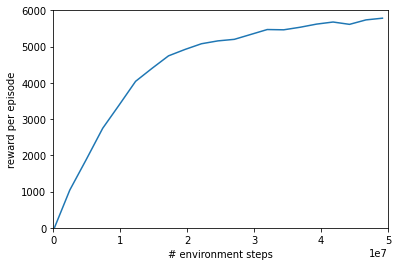

time to jit: 0:02:12.582129
time to train: 0:01:34.493779


In [ ]:
#@title Training some pre-included Brax environments

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'ant': functools.partial(
      ppo.train, num_timesteps = 50000000, log_frequency = 20,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 5, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 1e-2, num_envs = 2048, batch_size = 1024
  ),
  'humanoid': functools.partial(
      sac.train, num_timesteps = 1048576 * 5,
      log_frequency = 131012, reward_scaling = 30, episode_length = 1000,
      normalize_observations = True, action_repeat = 1, discounting = 0.99,
      learning_rate = 6e-4, num_envs = 64, batch_size = 512,
      min_replay_size = 8192, max_replay_size = 1048576,
      grad_updates_per_step = 0.125, max_devices_per_host=4
  ),
  'fetch': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 20,
      reward_scaling = 5, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 4, discounting = 0.997, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'grasp': functools.partial(
      ppo.train, num_timesteps = 600_000_000, log_frequency = 10,
      reward_scaling = 10, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 2, discounting = 0.99, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 256
  ),
  'halfcheetah': functools.partial(
      ppo.train, num_timesteps = 100_000_000, log_frequency = 10,
      reward_scaling = 1, episode_length = 1000, normalize_observations = True,
      action_repeat = 1, unroll_length = 20, num_minibatches = 32,
      num_update_epochs = 8, discounting = 0.95, learning_rate = 3e-4,
      entropy_cost = 0.001, num_envs = 2048, batch_size = 512
  ),
}[env_name]
max_y = {'ant': 6000, 'humanoid': 12000, 'fetch': 15, 'grasp': 100, 'halfcheetah': 8000}[env_name]

xdata = []
ydata = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([0, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

inference_fn, params, _ = train_fn(environment_fn=env_fn, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function and the final set of metrics gathered during evaluation.  Here, we take the inference function and visualize one episode's trajectory:

In [ ]:
#@title Visualizing a trajectory of the learned inference function

jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)
qps = []
while not state.done:
  qps.append(state.qp)
  act = jit_inference_fn(params, state.obs, state.rng)
  state = jit_env_step(state, act)

visualize(env.sys, qps)